In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import time
import io
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


def initialization(seed=42):
    keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)

# 使用Character RNN生成莎士比亚风格的文本

## 创建训练数据集 Creating the Training Dataset

1. 使用`Keras`的`get_file()`函数，从项目中下载所有莎士比亚的作品

In [2]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)

with open(filepath) as f:
    shakespeare_text = f.read()

1130496/1115394 [==============================] - 0s 0us/step


In [3]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [4]:
"".join(sorted(set(shakespeare_text.lower())))   # 显示文本中出现的所有字符

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

2. 将每个字符编码为一个整数。
    - 创建一个自定义预处理层，
    - 或使用`Keras`的`分词器Tokenizer`会更加简单。
    
> **tf.keras.preprocessing.text.Tokenizer**
> ```python   
tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',  
    # filters过滤: 不包含 '
    lower=True,   # 是否转化为小写
    split=' ',
    char_level=False,   # true: 每个字符都将被视为一个标记
    oov_token=None,
    document_count=0,
    **kwargs
)
> ```   
> 
> 默认情况下，所有标点符号都被删除，将文本转换为空格分隔的单词序列（单词可能包括 ' 字符）。然后将这些序列拆分为分词列表。然后它们将被索引或矢量化。
0 是一个保留索引，不会分配给任何单词。
>
> `fit_on_texts(texts)` : 根据文本列表更新内部词汇表
>
> `fit_on_sequences(texts)` : 根据序列列表更新内部词汇表
>
> `get_config()` : 根据文本列表更新内部词汇表

- 首先，将一个将`tokenizer`拟合到文本：`tokenizer`能从文本中发现所有的字符，并将所有字符映射到不同的字符ID，**映射从1开始**.
- 设置`char_level=True`，以得到**字符级别的编码**，而不是默认的单词级别的编码。这个`tokenizer`默认**将所有文本转换成了小写**（如果不想这样，可以设置`lower=False`）

In [5]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

- 现在`tokenizer`可以将一整句（或句子列表）编码为`字符ID列表`，这可以告诉我们文本中有多少个独立的字符，以及总字符数.

In [6]:
tokenizer.texts_to_sequences(['First'])

[[20, 6, 9, 8, 3]]

In [7]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])   # 不区分大小写

['f i r s t']

In [8]:
# 列出字符索引
tokenizer.word_index

{' ': 1,
 'e': 2,
 't': 3,
 'o': 4,
 'a': 5,
 'i': 6,
 'h': 7,
 's': 8,
 'r': 9,
 'n': 10,
 '\n': 11,
 'l': 12,
 'd': 13,
 'u': 14,
 'm': 15,
 'y': 16,
 'w': 17,
 ',': 18,
 'c': 19,
 'f': 20,
 'g': 21,
 'b': 22,
 'p': 23,
 ':': 24,
 'k': 25,
 'v': 26,
 '.': 27,
 "'": 28,
 ';': 29,
 '?': 30,
 '!': 31,
 '-': 32,
 'j': 33,
 'q': 34,
 'x': 35,
 'z': 36,
 '3': 37,
 '&': 38,
 '$': 39}

In [9]:
# 字符索引数
max_id = len(tokenizer.word_index)
max_id

39

In [10]:
# 总字符数
dataset_size = tokenizer.document_count
dataset_size

1115394

- 现在对完整文本做编码，将每个字符都用ID来表示（减1**使ID从0到38**，而不是1到39）

In [11]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) -1
encoded  

array([19,  5,  8, ..., 20, 26, 10])

## 如何区分序列数据集 How to Split a Sequential Dataset

避免训练集、验证集、测试集发生重合非常重要。

当处理时间序列时，
- 通常按照时间切分,
- 也可以按照其它维度来切分，可以得到更长的时间周期进行训练。如果训练集中的数据存在高度关联性, 则测试集的意义就不大，泛化误差会存在偏移。

在莎士比亚案例中, 可以取90%的文本作为训练集，5%作为验证集，5%作为测试集。在这三个数据之间留出空隙，以避免段落重叠也是非常好的主意。

创建`tf.data.Dataset`, 可以从数据集中一个个返回字符.

In [12]:
train_size = dataset_size * 90 // 100     # train_size=1003854
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

2022-04-17 12:51:17.410582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 12:51:17.531258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 12:51:17.532285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 12:51:17.535076: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## 将序列数据集切分成多个窗口 Chopping the Sequential Dataset into Multiple Windows

### 示例

1. 让我们将序列 0 到 14 拆分为长度为 5 的窗口，每个窗口移动 2

        [0, 1, 2, 3, 4], [2, 3, 4, 5, 6], [4, 5, 6, 7, 8], ....
    
2. 然后将它们打乱，并将它们拆分为`inputs`（前 4 步）和`targets`（后 4 步）

        [2, 3, 4, 5, 6] 将被拆分为 [[2, 3, 4, 5], [3, 4, 5, 6]])
  
3. 然后创建 3 个这样的`inputs`/`targets`对的批次

In [13]:
initialization(42)

- 调节`n_steps`：用短输入序列训练`RNN`更为简单，但是因此`RNN`学不到任何长度超过`n_steps`的规律，所以`n_steps`不要太短。

In [14]:
n_steps = 5
test_dataset = tf.data.Dataset.from_tensor_slices(tf.range(16))

- 使用数据集的`window()`，将这个**长序列转化为许多小窗口文本**。每个实例都是完整文本的相对短的子字符串，`RNN`只在这些子字符串上展开。这被称为`截断沿时间反向传播truncated backpropagation through time`
    >
    > ```python
    window(
        size, 
        shift=None, 
        stride=1, 
        drop_remainder=False,   
        name=None
    )
    > ```
    > - `drop_remainder`:如果最后一个窗口的大小小于 `size`，是否应该删除最后一个窗口。
    > - `shift`: 表示**窗口**在每次迭代中**移动**的输入元素的数量.
    > - `stride`: 步幅,默认为1

In [15]:
test_dataset = test_dataset.window(size=n_steps, 
                                   shift=2, 
                                   drop_remainder=True)

for ds in test_dataset:
    print( [elem.numpy() for elem in ds])

[0, 1, 2, 3, 4]
[2, 3, 4, 5, 6]
[4, 5, 6, 7, 8]
[6, 7, 8, 9, 10]
[8, 9, 10, 11, 12]
[10, 11, 12, 13, 14]


2022-04-17 12:51:21.700117: W tensorflow/core/framework/dataset.cc:679] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-04-17 12:51:21.707061: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-04-17 12:51:21.716447: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


    迭代次数: ( len(text)-window_size )//shift +1 = (16-5)//2+1 = 6

- 使用`window()`,返回一个嵌套的数据,类似于`list of lists`. 当调用数据集方法处理（比如`shuffle`或做`batch`）每个窗口时，这样会很方便。

    但是，不能直接使用嵌套数据集来训练，因为模型要的输入是`tensors`，不是`datasets`。因此，必须调用`flat_map()`方法：
    > - `flat_map()`:它能将嵌套数据集转换成**展平**的数据集。
    > 
    >   例: 假设 `{1, 2, 3}` 表示包含张量1、2、3的序列。如果将嵌套数据集 `{{1, 2}, {3, 4, 5, 6}}` 打平，就会得到` {1, 2, 3, 4, 5, 6}` 。
    >
    >
    > - `flat_map()`方法可以接收函数作为参数，可以处理嵌套数据集的每个数据集。
    >
    >   例: 如果将函数 `lambda ds: ds.batch(2)` 传递给 `flat_map()` ，它能将 `{{1, 2}, {3, 4, 5, 6}}` 转变为` {[1, 2], [3, 4], [5, 6]}` ：这是一个张量大小为2的数据集。
    >
    >   每个窗口上调用了`batch(window_length)`：因为所有窗口都是这个长度，对于每个窗口，都能得到一个独立的张量。


In [16]:
test_dataset = test_dataset.flat_map(lambda windows: windows.batch(5))

for ds in test_dataset:
    print([elem.numpy() for elem in ds])

[0, 1, 2, 3, 4]
[2, 3, 4, 5, 6]
[4, 5, 6, 7, 8]
[6, 7, 8, 9, 10]
[8, 9, 10, 11, 12]
[10, 11, 12, 13, 14]


2022-04-17 12:51:22.517172: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


- 现在的数据集包含连续的窗口，每个有5个字符。因为梯度下降在训练集中的实例`独立同分布`时的效果最好，需要`shuffle`这些窗口。然后我们可以对窗口做`batch`，分割`inputs`（前4个字符）和`targets`(除去第一个字符)

In [17]:
test_dataset = test_dataset.shuffle(10).map(lambda windows:
                                            (windows[:-1], windows[1:]))
test_dataset = test_dataset.batch(3).prefetch(1)

In [18]:
for index, (X_batch, Y_batch) in enumerate(test_dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


### 使用在莎士比亚数据集上

<img src="./images/other/16-1.png" width="500">

In [19]:
initialization(42)

n_steps = 100
window_length = n_steps + 1  # target = input 后面的 1 个字符
batch_size = 32

In [20]:
dataset = dataset.window(size=window_length, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))

    train_size=1003854
    迭代次数: ( len(text)-window_size ) // shift +1 
           = ( 1003854 - 101 ) // 1 + 1 = 1003754
    即: 共有1003754个窗口, 每个窗口大小为101

In [21]:
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

- 特征编码可以选择`独热编码`或`嵌入`。这里使用**独热编码**，因为独立字符不多.

In [22]:
dataset = dataset.map(lambda X_batch, Y_batch:
                      (tf.one_hot(X_batch, depth=max_id), Y_batch))

- `prefetch()`实现预提取

In [23]:
dataset = dataset.prefetch(1)

In [24]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## 搭建并训练Char-RNN模型 Building and Training the Char-RNN Model

根据前面的100个字符预测下一个字符:

- 使用一个`RNN`，含有两个`GRU`层，每个128个单元，每个单元对`输入dropout`和`隐藏态recurrent_dropout`的丢失率是20%。如果需要的话，后面可以微调这些超参数。

- 输出层是一个时间分布的紧密层，有39个单元,即`max_id`，因为文本中有39个不同的字符，需要输出每个可能字符（在每个时间步）的概率。

> 注意：当使用以下参数的默认值时，`GRU` 类将只使用 `GPU`（如果有的话）：`activation`、`recurrent_activation`、`recurrent_dropout`、`unroll`、`use_bias` 和 `reset_after`。
>
> 详见: https://tensorflow.google.cn/versions/r2.0/api_docs/python/tf/keras/layers/GRU

In [25]:
model = keras.models.Sequential([
    keras.layers.GRU(128,
                     return_sequences=True,
                     input_shape=[None, max_id],
                     # dropout=0.2, recurrent_dropout=0.2
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True, dropout=0.2),
    keras.layers.TimeDistributed(
        keras.layers.Dense(max_id, activation="softmax"))
])

In [26]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=20)

Epoch 1/20


2022-04-17 12:51:35.929913: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


31368/31368 [==============================] - 382s 12ms/step - loss: 1.6206
Epoch 2/20
31368/31368 [==============================] - 375s 12ms/step - loss: 1.5369
Epoch 3/20
31368/31368 [==============================] - 378s 12ms/step - loss: 1.5170
Epoch 4/20
31368/31368 [==============================] - 383s 12ms/step - loss: 1.5057
Epoch 5/20
31368/31368 [==============================] - 379s 12ms/step - loss: 1.4983
Epoch 6/20
31368/31368 [==============================] - 383s 12ms/step - loss: 1.4929
Epoch 7/20
31368/31368 [==============================] - 377s 12ms/step - loss: 1.4893
Epoch 8/20
31368/31368 [==============================] - 378s 12ms/step - loss: 1.4866
Epoch 9/20
31368/31368 [==============================] - 391s 12ms/step - loss: 1.4845
Epoch 10/20
31368/31368 [==============================] - 371s 12ms/step - loss: 1.4823
Epoch 11/20
31368/31368 [==============================] - 385s 12ms/step - loss: 1.4808
Epoch 12/20
31368/31368 [================

In [27]:
model.save("./models/my_CharRNN_model.h5")

In [28]:
model = keras.models.load_model('./models/my_CharRNN_model.h5')

## 使用Char-RNN模型 Using the Char-RNN model

- 首先需要对数据进行预处理
    
    对文本进行编码，将每个字符都用ID来表示(从0开始), 并使用独热编码.

In [29]:
def preprocess(tests):
    X = np.array(tokenizer.texts_to_sequences(tests)) - 1
    return tf.one_hot(X, max_id)

- 接下来可以使用这个模型,预测文本中的下一个字母.

In [30]:
X_new = preprocess(["I love yo"])
y_pred = np.argmax(model(X_new), axis=-1)

In [31]:
# 打印第一句话所有时间窗的最后一个字符
tokenizer.sequences_to_texts(y_pred + 1)[0]  

'n h i v e   t o u'

In [32]:
# 打印最后的预测结果
tokenizer.sequences_to_texts(y_pred + 1)[0][-1]

'u'

## 生成假莎士比亚文本 Generating Fake Shakespearean Text

要使用`Char-RNN`生成新文本，我们可以给模型输入一些文本，让模型预测出下一个字母，**将字母添加到文本的尾部，再将延长后的文本输入给模型，预测下一个字母**，以此类推。但在实际中，这会导致相同的单词不断重复。

- 可以使用`tf.random.categorical()`，**随机挑选下一个字符**，概率等同于`估计概率`。

    根据分类的`对数几率logits`，`categorical()`从分类索引中随机抽取样本。

In [33]:
initialization(42)

tf.random.categorical(logits=[[np.log(0.1),
                               np.log(0.7),
                               np.log(0.1),]],
                      num_samples=10).numpy()   # 为每个行切片绘制的独立样本数

array([[1, 2, 1, 1, 1, 0, 1, 1, 1, 1]])

为了对生成文本的多样性更可控，我们可以用一个称为`temperature`的可调节的数来除以对数概率：`temperature`接近0，会利于高概率字符，而非常高的`temperature`将给所有字符的相等概率。

- 下面的`next_char()`函数使用这个方法，来挑选添加进文本中的字符

In [34]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]  # 0: 表示第一段文本
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    char = tokenizer.sequences_to_texts(char_id.numpy())[0]
    return char

In [35]:
initialization(42)

next_char(text="I love yo", temperature=1)

'u'

- 重复调用`next_char()`, 并测试不同的`temperature`:

In [36]:
initialization(42)

In [37]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [38]:
print(complete_text("t", temperature=0.2))

ther fair bianca, i will be so fair bianca,
and if 


In [39]:
print(complete_text("t", temperature=0.1))

ther for my father is a scolding to her fair
for my


In [40]:
print(complete_text("t", temperature=2))

tpeniomed lace? tignify: yel 'pageth him ruch-eaper


显然，当`temperature=1`时，我们的莎士比亚模型效果最好。

为了生成更有信服力的文字，**可以尝试用更多`GRU层`、每层更多的神经元、更长的训练时间，添加正则**（例如，可以在`GRU层`中设置`recurrent_dropout=0.3`）。另外，模型不能学习长度超过`n_steps`（只有100个字符）的规律。你可以**使用更大的窗口**，但也会让训练更为困难，甚至`LSTM`和`GRU`单元也不能处理长序列。

另外，还可以使用`有状态RNN`.

## 有状态RNN  Stateful RNN

### 原理及数据集划分

在Keras调用`LSTM/GRU`的参数中，有一个`stateful`参数，默认是`False`，也就是`无状态模式stateless`，为`True`的话就是`有状态模式stateful`.

>- `stateless LSTM`
>  
>  `stateless`就是与`stateful`相反了，就是sample之间没有前后状态传递的关系，输入samples后，默认就会shuffle，可以说是**每个sample独立**，适合输入一些没有关系的样本。

> - `stateful LSTM`
>    
>    除了正常的单个sample内部时间步之间的状态互相传递外，sample之间的状态还能互相传递。但是需要确定`batch_size`大小，传递的时候是前一个`batch`的第$i$个sample最终输出状态，传递给后一个`batch`的第$i$个sample，作为其状态的初始化值。
>     
>         解放军第72集团军某旅500名抗洪子弟兵撤离安徽铜陵枞阳县，赶赴合肥庐江县继续抗洪。当地百姓冒着大雨追着驶出的车辆，递上自家的莲蓬、葡萄、熟鸡蛋等食物，送别子弟兵。
    第一句话为一个sample，第二句话为第二个sample，每个sample内部的word为一个时间步，很明显前后两个sample是相互关联的。**如果设置`batch_size=1`,则第一句话最终输出状态(即最后一个word的状态输出)，就可以传递给第二句话作为其初始状态值**。
>    
>   - 优点：后面的语句有了更合理的初始化状态值，显然会加快网络的收敛，所以需要更小的网络、更少的训练时间。
>   - 缺点：每一个`epoch`后，要重置一下状态，因为训练一遍了，状态不能循环使用，要从头开始。
>   - 使用注意事项：**调用`fit()` 时指定 `shuffle = False`**，要保证sample之间的前后顺序；可以使用`model.reset_states()`来重置模型中所有层的状态，也可使用`layer.reset_states()`来重置指定有状态 RNN 层的状态。



> 参考: https://www.cnblogs.com/gczr/p/13393883.html

`stateful RNN`只在前一批次的序列离开，后一批次中的对应输入序列开始的情况下才有意义。

- 首先,**使用序列且没有重叠的输入序列**（而不是用来训练无状态RNN时的打散和重叠的序列）。
    - 当创建`Dataset`时，**调用`window()`必须使用`shift=n_steps`**（而不是`shift=1`）。
            例: window_size=31, shfit=30, 
                train_x=[1,...,31] (31-1=30), train_y=[2,...,31], 
                next, train_x=[31,...,61], train_y=[32...62],
    - 不能使用`shuffle()`方法。但是，准备`stateful RNN`数据集的批处理会麻烦些。事实上，如果调用`batch(32)`，32个连续的窗口会放到一个相同的批处理中，而下一个批处理不会再这些窗口的每个中断处继续。第一个批次含有窗口1到32，第二个批次批次含有窗口33到64，因此每个批次中的第一个窗口（第一批次的窗口1和第二批次的窗口33），它们是不连续的。
  
  
- 最简单办法是**使用只包含单个窗口的"批处理"**：
   <img src="./images/other/16-2.png" width="500">

In [41]:
initialization(42)

n_steps = 100 
window_length = n_steps + 1  

In [42]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(size=window_length,
                         shift=n_steps,
                         drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))

dataset = dataset.repeat().batch(1)  # 注意不同与前文.batch(batch_size)
dataset = dataset.map(lambda window:(window[:, :-1], window[:, 1:]))

dataset = dataset.map(lambda X_batch, y_batch: (tf.one_hot(X_batch, max_id), y_batch))

dataset = dataset.prefetch(1)

In [43]:
for X_batch, y_batch in dataset.take(1): 
    print(X_batch.shape, y_batch.shape) 

(1, 100, 39) (1, 100)


- 使用以下方法也可以**实现批处理**
   - 将莎士比亚作品切分成32段等长的文本
   - 每个文本创建一个连续输入的数据集
   - 最后使用`tf.train.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))`来创建合适的连续批处理，其中批处理中的第$n$个输入序列恰好是上一个批处理中第$n$个输入序列结束位置的开始.

In [44]:
batch_size = 32
encoded_parts = np.array_split(ary=encoded[:train_size],
                               indices_or_sections=batch_size)
# 划分为32段等长的文本
# 每段31371个字符, 最后一段为31370

In [45]:
datasets = []

for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(size=window_length,
                             shift=n_steps,
                             drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)

    encoded_part_size=31371
    迭代次数: ( len(text)-window_size ) // shift +1 
           = ( 31371 - 101 ) // 100 + 1 = 313
    即: 共有313个窗口, 每个窗口大小为101

In [46]:
dataset = tf.data.Dataset.zip(
    tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset

<MapDataset shapes: (32, None), types: tf.int64>

In [47]:
dataset = dataset.map(lambda window: (window[:, :-1], window[:, 1:]))
dataset = dataset.map(lambda X_batch, y_batch:
                      (tf.one_hot(X_batch, max_id), y_batch))
dataset = dataset.prefetch(1)

In [48]:
for X_batch, y_batch in dataset.take(1): 
    print(X_batch.shape, y_batch.shape) 

(32, 100, 39) (32, 100)


### 搭建并训练模型

1. 搭建`stateful RNN`模型
    - 创建每个循环层时需要**设置`stateful=True`**
    - 有状态RNN需要知道批次大小（因为要为批次中的每个输入序列保留一个状态），所以要必须在第一层中设置`batch_input_shape`。
        - 注意:可以不用指定第二个维度，因为输入可以有任意长度.

In [49]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2,),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

2. 在每个`epoch`之后, 需要先重设状态, 然后再返回到文本的开头。因此, 我们需要使用回调函数.

In [50]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [51]:
EarlyStoppingCallback = keras.callbacks.EarlyStopping(patience=10,  # 至多10个轮次
                                                      restore_best_weights=True)

3. 编译并训练模型

In [52]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=100,
                    callbacks=[ResetStatesCallback(), EarlyStoppingCallback])

Epoch 1/100
313/313 [==============================] - 7s 15ms/step - loss: 2.6204
Epoch 2/100
313/313 [==============================] - 5s 15ms/step - loss: 2.2427
Epoch 3/100
313/313 [==============================] - 4s 14ms/step - loss: 2.1129
Epoch 4/100
313/313 [==============================] - 4s 14ms/step - loss: 2.0384
Epoch 5/100
313/313 [==============================] - 4s 14ms/step - loss: 1.9869
Epoch 6/100
313/313 [==============================] - 5s 15ms/step - loss: 1.9511
Epoch 7/100
313/313 [==============================] - 5s 15ms/step - loss: 1.9225
Epoch 8/100
313/313 [==============================] - 5s 15ms/step - loss: 1.8983
Epoch 9/100
313/313 [==============================] - 5s 15ms/step - loss: 1.8815
Epoch 10/100
313/313 [==============================] - 5s 15ms/step - loss: 1.8663
Epoch 11/100
313/313 [==============================] - 5s 14ms/step - loss: 1.8505
Epoch 12/100
313/313 [==============================] - 5s 15ms/step - loss: 1.8422
E

In [53]:
model.save("./models/my_stateful_RNN.h5")

In [54]:
history_dict = history.history
train_loss = history_dict["loss"]

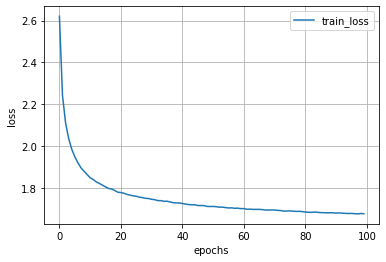

In [55]:
epochs = 100
# figure 1
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')
plt.legend()
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

4. 创建无状态副本模型

    训练此模型后，只能使用它来预测**与训练期间使用的大小相同的批次**。为避免此限制，要**创建一个相同的无状态模型，并将有状态模型的权重复制到此模型**。 
    
    我们可以摆脱 dropout，因为它只在训练期间使用.

In [56]:
model = keras.models.load_model('./models/my_stateful_RNN.h5')

    要设置权重，我们首先需要构建模型.

In [57]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(
        keras.layers.Dense(max_id, activation="softmax"))
])

In [58]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [59]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

5. 测试字符级模型

In [60]:
def preprocess(tests):
    X = np.array(tokenizer.texts_to_sequences(tests)) - 1
    return tf.one_hot(X, max_id)

def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]  # 0: 表示第一段文本
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    char = tokenizer.sequences_to_texts(char_id.numpy())[0]
    return char

def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [61]:
initialization(42)

In [62]:
print(complete_text("t"))

tis no doubt honour.
and vens him. belight you to m


# 情感分析 Sentiment Analysis

`IMDb影评数据集`包含50000条英文影评，25000条用于训练，25000条用于测试，是从IMDb网站提取的，并带有影评标签，负（0）或正（1）。

- 使用`keras`加载`IMDb影评数据集`

In [2]:
initialization(42)

In [3]:
(X_train, y_train), (X_text, y_text) = keras.datasets.imdb.load_data()

In [4]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

- 数据集已经经过预处理:
    1.  `X_train`由一个评论的列表构成，每条评论都是整数NumPy数组，其中每个整数代表一个词。
    2. 所有标点符号都被删除， 然后将单词转换为小写字母，用空格隔开，最后用频次建立索引。
    3. 整数0、1、2是特殊的
        -  0:\<pad>表示`填充token`
        -  1:\<sos>表示`序列开始(SSS)token`
        -  2:\<unk>表示`未知单词`

- 可视化评论

In [5]:
word_index = keras.datasets.imdb.get_word_index()  # len(word_index):88584
sorted(word_index.items(), key=lambda x: x[1])[:10]

[('the', 1),
 ('and', 2),
 ('a', 3),
 ('of', 4),
 ('to', 5),
 ('is', 6),
 ('br', 7),
 ('in', 8),
 ('it', 9),
 ('i', 10)]

In [6]:
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
id_to_word

{34704: 'fawn',
 52009: 'tsukino',
 52010: 'nunnery',
 16819: 'sonja',
 63954: 'vani',
 1411: 'woods',
 16118: 'spiders',
 2348: 'hanging',
 2292: 'woody',
 52011: 'trawling',
 52012: "hold's",
 11310: 'comically',
 40833: 'localized',
 30571: 'disobeying',
 52013: "'royale",
 40834: "harpo's",
 52014: 'canet',
 19316: 'aileen',
 52015: 'acurately',
 52016: "diplomat's",
 25245: 'rickman',
 6749: 'arranged',
 52017: 'rumbustious',
 52018: 'familiarness',
 52019: "spider'",
 68807: 'hahahah',
 52020: "wood'",
 40836: 'transvestism',
 34705: "hangin'",
 2341: 'bringing',
 40837: 'seamier',
 34706: 'wooded',
 52021: 'bravora',
 16820: 'grueling',
 1639: 'wooden',
 16821: 'wednesday',
 52022: "'prix",
 34707: 'altagracia',
 52023: 'circuitry',
 11588: 'crotch',
 57769: 'busybody',
 52024: "tart'n'tangy",
 14132: 'burgade',
 52026: 'thrace',
 11041: "tom's",
 52028: 'snuggles',
 29117: 'francesco',
 52030: 'complainers',
 52128: 'templarios',
 40838: '272',
 52031: '273',
 52133: 'zaniacs',

In [7]:
imdb_word = [word for word, id_ in word_index.items()]
len(imdb_word)

88584

In [8]:
for id_, token in enumerate(["<pad>", "<sos>", "<unk>"]):
    id_to_word[id_] = token

In [9]:
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

'<sos> this film was just brilliant casting location scenery story'

## 预处理文本

在真实的项目中，必须要自己预处理文本。

- 使用前面用过的`Tokenizer`
    - 设置`char_level=False`(默认的).
    - 当编码单词时，`Tokenizer`会过滤掉许多字符, 使用`filters`进行过滤.
    - `Tokenizer`使用空格确定单词的边界, 对于非英语语言并不通用.
- *Taku Kudo*提出的一种无监督学习技术，用一种独立于语言的方式在**子单词级别**对文本进行`分词tokenize`和`组词detokenize`。这使得模型可以推断出没有见识过的单词.
                  smart √  -est √      →   smartest
- *Rico Sennrich*创建子字编码的其他方法（例如，使用字节对编码）
- `TF.Text 库`，该库实现了各种分词策略，包括 `Word Piece`（字节对编码的一种变体）

1. **从`tfds`上下载`IMDB`数据集**

    详情: https://tensorflow.google.cn/datasets/catalog/imdb_reviews

In [10]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

datasets.keys()

dict_keys(['train', 'test', 'unsupervised'])

In [11]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

train_size, test_size

(25000, 25000)

2. **可视化评论**

In [12]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("评论:", review.decode('utf-8')[:200], "...")
        print("情感标签:", label, "= Position" if label else "= Nagative")
        print()

评论: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
情感标签: 0 = Nagative

评论: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
情感标签: 0 = Nagative



3. **预处理函数**
    - **截断评论**: 每条评论只保留前300个字符: 加快训练速度, 对性能影响小.
    - **替换标识**:
        - 使用空格替换`<br />`
            ```python
            tf.strings.regex_replace(X_batch, b"<br\s*/?>", b" ")
            ```
        - 使用空格替换除了字母和引号外其他所有字符
            ```python
            tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
            ```
    - **分词**: 按照**空格**进行分割, 返回一个`不规则ragged张量`
    - **填充**: 将这个张量转换为`密集dense张量`, 使用**填充token**`<pad>` 填充所有评论, 使它们具有相同的长度 
            

In [13]:
def preprocess(X_batch, y_batch):
    # 截断评论
    X_batch = tf.strings.substr(input=X_batch, pos=0, len=300)
    # 替换标识
    X_batch = tf.strings.regex_replace(X_batch, b"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    # 分词
    X_batch = tf.strings.split(X_batch)
    # 填充  [1,2,3],[],[4,5] -> [1,2,3],[0,0,0],[4,5,0]
    X_batch = X_batch.to_tensor(default_value=b"<pad>")
    return X_batch, y_batch

In [14]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

4. **构建词汇表**

    遍历整个训练集, 应用`preprocess()`，并使用 `Counter` 来计算每个单词的出现次数.

In [15]:
from collections import Counter

vocabulary = Counter()
train_set = datasets["train"].batch(32).map(preprocess)

for X_batch, y_batch in train_set:
    for review in X_batch:
        vocabulary.update(review.numpy())

    查看最常见的三个词:

In [16]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [17]:
len(vocabulary)

53893

5. **截断词汇表**的前1 0000个单词, 以获取更好的性能.

In [18]:
vocabulary_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocabulary_size]
]

In [19]:
truncated_vocabulary[:3]

[b'<pad>', b'the', b'a']

6. **建立**词汇表的**索引**
    
    详见`第13章 使用TensorFlow加载和预处理数据(1) 3.2使用独热向量编码分类特征`
    
    >- 首先定义词汇表,这是所有可能类别的列表.然后创建相应索引的张量.
    >- 为查找表创建一个初始化程序,将类别列表及其索引传递给它.
    >- 创建查找表,并为其提供初始化程序并指定了词汇表外`out-of-vocabulary (oov)桶`的数量.如果我们査找词汇表中不存在的类别，则査找表将计算该类别的哈希并将这个未知类別分配给`oov桶`之中的一个。它们的素引从已知类别开始，因此在此示例中，`oov桶`的索引为10001到11000.

In [20]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)

vocabulary_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)

num_oov_buckets = 10000
table = tf.lookup.StaticVocabularyTable(vocabulary_init, num_oov_buckets)

In [21]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 18053]])>

## 搭建并训练模型

现在，可以创建最终的训练集。
1. 首先对影评做批处理, 使用`preprocess()`将其转换为单词的短序列.
2. 然后使用一个简单的`encode_words()`对这些单词进行编码, 最后预提取下一个批次.

In [22]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

In [23]:
train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [24]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch.numpy())
    print()
    print(y_batch.numpy())

[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]]

[0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0]


3. 构建模型
    
    使用`Keras`提供的`Embedding`层实现嵌入.
    
    将所有单词ID转换为`嵌入`.嵌入矩阵需要每个单词ID（`vocab_size` + `num_oov_buckets`）, 每个嵌入维度一列. 模型输入是2D张量, 形状为 `[批次大小, 时间步]` , 嵌入层的输出是一个3D张量, 形状为 `[批次大小, 时间步, 嵌入大小]` .输出层使用`sigmoid`来输出估计概率的单个神经元, 该概率反应了评论表达与电影相关的正面情绪.


In [25]:
initialization(42)

In [26]:
embed_size = 128  # 嵌入维度
row = vocabulary_size + num_oov_buckets  # 53893+10000

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=row,
                           output_dim=embed_size,
                           mask_zero=True,
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),  # 仅返回最后一个时间步长的输出
    keras.layers.Dense(1, activation="sigmoid")
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
gru (GRU)                    (None, None, 128)         99072     
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,758,273
Trainable params: 2,758,273
Non-trainable params: 0
_________________________________________________________________


4. 训练模型

In [28]:
model.compile(
    loss="binary_crossentropy",  # 二元交叉熵
    optimizer="adam",
    metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 67s 79ms/step - loss: 0.5305 - accuracy: 0.7276
Epoch 2/5
782/782 [==============================] - 68s 87ms/step - loss: 0.3070 - accuracy: 0.8772
Epoch 3/5
782/782 [==============================] - 78s 99ms/step - loss: 0.1514 - accuracy: 0.9472
Epoch 4/5
782/782 [==============================] - 64s 82ms/step - loss: 0.0937 - accuracy: 0.9666
Epoch 5/5
782/782 [==============================] - 69s 88ms/step - loss: 0.0543 - accuracy: 0.9815


## 掩码遮蔽 Masking

该模型需要学习忽略掉`填充token`: 可在创建`Embedding层`添加`mask_zero=True`, 使得`填充token`被遮蔽, 因为其ID为0(频率最高).

> 其中的原理，是嵌入层创建了一个等于`K.not_equal(inputs, 0)`的`掩码张量`：这是一个布尔张量，形状和输入相同，**只要词ID有0，它就等于False，否则为True。只要时间维度保留着, 模型将自动将这个`掩码张量`向前传递给所有层。**
>
>    - 在本示例中，尽管两个`GRU`都接收到了`掩码张量`，但第二个`GRU`层不返回序列, 只返回最后一个时间步，`掩码张量`不会传递到`Dense`层。
>
> 每个层处理掩码的方式不同，但通常只会忽略被遮掩的时间步长（即掩码为False的时间步长）。例如，当循环层碰到被掩蔽的时间步长时，就只是从前一时间步长复制输出而已。 如果`掩码`一直传递到输出（输出为序列的模型），则它也会作用到损失上，所以被掩码的时间步长不会贡献到损失上（它们的损失为0）.
>
 `LSTM`和`GRU`层有基于`cuDNN`库的GUP优化的实现, 但是不支持掩码. 优化的实现还需要使用多个超参数默认值 具体详见`1.4`节

 所有接收掩码的层必须支持掩码（否则会抛出异常）。包括所有的循环层、`TimeDistributed`层和其它层。所有支持掩码的层必须`supports_masking=True`。

 - 如果想实现自定义的支持掩码的层，应该给`call()`方法添加`mask`参数。另外，要在构造器中设定`self.supports_masking = True`。
 - 如果第一个层不是`Embedding层`，可以使用`keras.layers.Masking层`: 它设掩码为`K.any(K.not_equal(inputs, 0), axis=-1)`，意思是最后一维都是0的时间步，会被后续层遮挡。

- **使用函数式API构建模型手动处理掩码**

 使用掩码层和自动掩码传播最适合简单的`Sequential`模型,不适合复杂的模型,这种情况需要使用函数式API或子类API来显性的计算掩码并传递到适当的层.

In [29]:
initialization(42)

In [30]:
K = keras.backend
embed_size = 128  # 嵌入维度
row = vocabulary_size + num_oov_buckets  # 53893+10000

In [31]:
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
Z = keras.layers.Embedding(input_dim=row, output_dim=embed_size)(inputs)
Z = keras.layers.GRU(128, return_sequences=True)(Z, mask=mask)
Z = keras.layers.GRU(128)(Z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(Z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       (None, None, 128)    99072       embedding[0][0]                  
                                                                 lambda[0][0]                 

In [33]:
model.compile(
    loss="binary_crossentropy",  # 二元交叉熵
    optimizer="adam",
    metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 71s 84ms/step - loss: 0.5305 - accuracy: 0.7276
Epoch 2/5
782/782 [==============================] - 74s 95ms/step - loss: 0.3070 - accuracy: 0.8772
Epoch 3/5
782/782 [==============================] - 61s 78ms/step - loss: 0.1514 - accuracy: 0.9472
Epoch 4/5
782/782 [==============================] - 57s 73ms/step - loss: 0.0937 - accuracy: 0.9666
Epoch 5/5
782/782 [==============================] - 58s 74ms/step - loss: 0.0543 - accuracy: 0.9815


In [34]:
model.save('./models/my_Masking_model.h5')

## 可视化嵌入向量

### Embedding Projector

1.首先, 我们将检索在训练期间学习的单词嵌入向量:

In [35]:
model = keras.models.load_model("./models/my_Masking_model.h5")

e = model.layers[1]
weight = e.get_weights()[0]
print(weight.shape)

(20000, 128)


2. 将权重写入磁盘。要使用 `Embedding Projector`，我们将以制表符分隔的格式上传两个文件：
    - 向量文件（包含嵌入向量）
    - 一个元数据文件（包含单词）

In [36]:
out_v = io.open('./Embedding/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('./Embedding/meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(truncated_vocabulary):
    word = word.decode("utf-8")
    vec = weight[num + 1]  # 跳过<pad>填充
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_m.close()
out_v.close()

3. 为了可视化嵌入向量，我们将它们上传到`Embedding Projector`: http://projector.tensorflow.org/
    - 打开`Embedding Projector`
    - 点击`Load data`
    - 上传我们在上面创建的两个文件：`vecs.tsv`和`meta.tsv`
    
 <img src="./images/other/16-3.png">

### TensorBoard

In [39]:
from tensorboard.plugins import projector

# 设置日志目录，以便 Tensorboard 知道在哪里查找文件。
log_dir = './Logs/SentimentAnalysis_logs/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
# 将我们要分析的权重保存为变量。
# 请注意，第一个 value 代表任何未知单词，它不在元数据中，这里我们将删除这个值。

weights = tf.Variable(model.layers[1].get_weights()[0][1:])
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# 张量的名称将以`/.ATTRIBUTES/VARIABLE _ VALUE`作为后缀。
embedding.tensor_name = "./Embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = './Embedding/meta.tsv'
projector.visualize_embeddings(log_dir, config)

In [40]:
%load_ext tensorboard
%tensorboard --logdir='./Logs/SentimentAnalysis_logs/' --port=6061

Reusing TensorBoard on port 6061 (pid 75488), started 13:22:04 ago. (Use '!kill 75488' to kill it.)

## 重用预训练的嵌入 Reusing Pretrained Embeddings

利用`TensorFlow Hub`项目, 在情感分析模型中使用`tf2-preview/nnlm-en-dim50`句子嵌入模块.

项目地址: https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1

本模块是一个`句子编码器`：它把字符串作为输入，并把每个字符串编码为一个独立向量（这个例子中是50维度的矢量）。在内部，它将字符串解析（空格分隔），然后使用在大型语料库`Google News 7B`(该语料库一共有70亿个词)上预训练的的嵌入矩阵来嵌入每个词。然后计算所有词嵌入的平均值，结果是`句子嵌入`。我们接着可以添加两个简单的`Dense`层来创建一个出色的情感分析模型。

默认，`hub.KerasLayer`是不可训练的，但创建时可以设定`trainable=True`，就可以针对自己的任务微调了。

In [41]:
initialization(42)

In [42]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "tfhub_cache")
# 将文件缓存目录添加到系统变量 避免每次系统清理之后再次下载
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [43]:
import tensorflow_hub as hub

model = keras.Sequential([
    # 将一维字符串张量中的一批句子作为输入
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string,
                   input_shape=[],
                   output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [44]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].batch(batch_size).prefetch(1)
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 2s 3ms/step - loss: 0.5461 - accuracy: 0.7267
Epoch 2/5
782/782 [==============================] - 2s 2ms/step - loss: 0.5130 - accuracy: 0.7493
Epoch 3/5
782/782 [==============================] - 2s 3ms/step - loss: 0.5082 - accuracy: 0.7522
Epoch 4/5
782/782 [==============================] - 2s 2ms/step - loss: 0.5047 - accuracy: 0.7544
Epoch 5/5
782/782 [==============================] - 2s 3ms/step - loss: 0.5018 - accuracy: 0.7557


> Apotosome 04/18/22